# Credit scoring

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

%pylab inline
%matplotlib inline  

Populating the interactive namespace from numpy and matplotlib


In [2]:
credit_data = pd.read_csv("credit_card.csv")
returned_data = credit_data[credit_data.default == 0]
not_returned_data = credit_data[credit_data.default == 1]
credit_data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
print(f"Size of returned credit data {len(returned_data)}")
print(f"Size of not returned credit data {len(not_returned_data)}")

Size of returned credit data 23364
Size of not returned credit data 6636


### Task1: LIMIT_BAL

### Part a

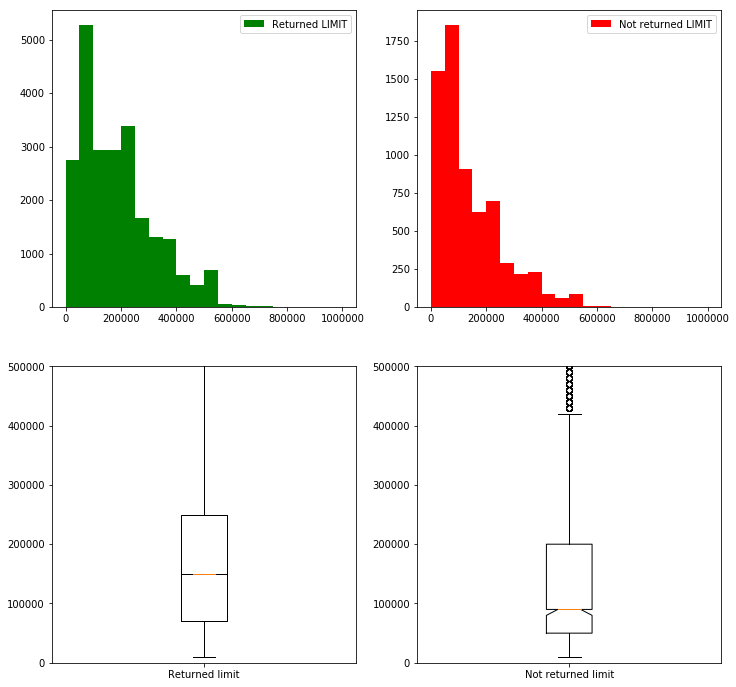

In [4]:
pylab.figure(figsize=(12,12))
pylab.subplot(2,2,1)
pylab.hist(returned_data.LIMIT_BAL, bins=20, label="Returned LIMIT", color="g", range=(0, 1000000))
pylab.legend()

pylab.subplot(2,2,2)
pylab.hist(not_returned_data.LIMIT_BAL, bins=20, label="Not returned LIMIT", color="r", range=(0, 1000000))
pylab.legend()

pylab.subplot(2,2,3)
pylab.boxplot(returned_data.LIMIT_BAL, notch=True, bootstrap=1000, labels=['Returned limit'])
pylab.ylim(0, 500000)

pylab.subplot(2,2,4)
pylab.boxplot(not_returned_data.LIMIT_BAL, notch=True, bootstrap=1000,labels=['Not returned limit'])
pylab.ylim(0, 500000)
pylab.show()

The groups size is different, so we can see higher values on the Returned limit histogram, however overall distributions look very similar. There are not much people with huge limits, and most of the people have limit between 0 and 4000000. 
For returned limit histogram there are less limits around zero and more limits between 200000 and 600000 if we compare to the not-returned limits. It's not a good idea to compare medians looking at histograms, let's check pointwise and interval differences. 

Also provided additional boxplots which are using bootstrap internally, those plots are much better to look at. We can observe that returned group limit median is higher, but let's proceed with more formal methods.

In [5]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [6]:
# get values first
returned_balance_values     = returned_data.LIMIT_BAL.values
not_returned_balance_values = not_returned_data.LIMIT_BAL.values

returned_balance_median_scores     = list(map(np.median, get_bootstrap_samples(returned_balance_values, 1000)))
not_returned_balance_median_scores = list(map(np.median, get_bootstrap_samples(not_returned_balance_values, 1000)))

In [7]:
# Pointwise
print("Pointwise difference between medians:", np.median(returned_balance_values) - np.median(not_returned_balance_values))

# Confidence interval of returned/not-returned group limit median
print("95% confidence interval for the returned group limit",  stat_intervals(returned_balance_median_scores, 0.05))
print("95% confidence interval for the not returned group limit",  stat_intervals(not_returned_balance_median_scores, 0.05))

print()
# Confidence interval of difference between medians
delta_median_scores = list(map(lambda x: x[0] - x[1], zip(returned_balance_median_scores, not_returned_balance_median_scores)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

Pointwise difference between medians: 60000.0
95% confidence interval for the returned group limit [150000. 150000.]
95% confidence interval for the not returned group limit [80000. 90000.]

95% confidence interval for the difference between medians [60000. 70000.]


With the alpha 0.05 the 95% confidence interval of the median difference(returned vs non-returned) lies between 60000 and 70000.

### part b

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

(H1): distributions are equal but shifted is alternative to (H0): distributions are equal

In [8]:
from scipy.stats import mannwhitneyu

# conditions for this criteria are partially satisfied (note: this impl does autocorrection for ties/duplicate values)
# so, let's keep it here, but use permutation criteria instead
mannwhitneyu(returned_balance_values, not_returned_balance_values, alternative="two-sided")

MannwhitneyuResult(statistic=95786286.5, pvalue=1.2255485818223303e-189)

In [9]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in list(range(max_combinations - 1)):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [10]:
print("p-value: %f" % permutation_test(returned_balance_values, not_returned_balance_values, max_permutations = 3000))

p-value: 0.000333


p-value is below the alpha=0.05, i.e. we can safely reject H0 in favor if H1, in other words distributions are not the same, they are different. From the previous calculations we know that the difference lies between 60000 and 700000 which is practically significant value. If we assume that max limit is around 600000(in fact average is even less) it's about 10% difference.

### Task2: SEX

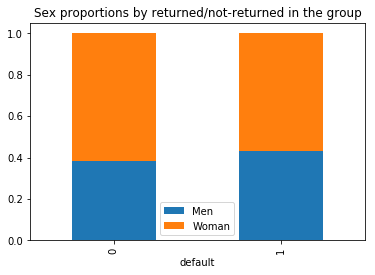

SEX,1,2
default,,
0,0.385850,0.614150
1,0.432942,0.567058


In [11]:
import matplotlib.pyplot as plt

# we need to build a table of men/woman proportions and default
sexy_data_stack = credit_data[["default", "SEX"]].groupby(["default", "SEX"]).size()
sexy_data = sexy_data_stack.unstack()
sexy_data.iloc[0] /= sexy_data.iloc[0].sum()
sexy_data.iloc[1] /= sexy_data.iloc[1].sum()

fig, ax = subplots()
sexy_data.plot(kind='bar', stacked=True, title="Sex proportions by returned/not-returned in the group", ax=ax)
ax.legend(["Men", "Woman"])

pylab.show()
sexy_data

default,0,1
SEX,,
1,0.758328,0.241672
2,0.792237,0.207763


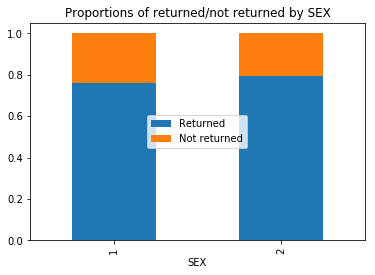

In [12]:
# we need to build a table of men/woman proportions and default
sexy_data2_stack = credit_data[["SEX", "default"]].groupby(["SEX", "default"]).size()
sexy_data2 = sexy_data2_stack.unstack()
sexy_data2.iloc[0] /= sexy_data2.iloc[0].sum()
sexy_data2.iloc[1] /= sexy_data2.iloc[1].sum()

fig, ax = subplots()
sexy_data2.plot(kind='bar', stacked=True, title="Proportions of returned/not returned by SEX", ax=ax)
ax.legend(["Returned", "Not returned"], loc="center")

#pylab.show()
sexy_data2

Proportions are not that different. Let's try to use some confidence intervals to see the difference.

In [13]:
import scipy
from statsmodels.stats.proportion import *

In [14]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

Let's check confidence intervals for proportion difference of men and woman in returned/not-returned groups

In [15]:
men_returned = returned_data.SEX.apply(lambda x: 1 if x==1 else 0)
men_not_returned = not_returned_data.SEX.apply(lambda x: 1 if x==1 else 0)

print("confidence interval of proportion difference for men: [%f, %f]" % 
      proportions_confint_diff_ind(men_returned, men_not_returned))

woman_returned = returned_data.SEX.apply(lambda x: 1 if x==2 else 0)
woman_not_returned = not_returned_data.SEX.apply(lambda x: 1 if x==2 else 0)
print("confidence interval of proportion difference for woman: [%f, %f]" % 
      proportions_confint_diff_ind(woman_returned, woman_not_returned))

confidence interval of proportion difference for men: [-0.060548, -0.033635]
confidence interval of proportion difference for woman: [0.033635, 0.060548]


This confirms what we saw on the "Sex proportions by group" diagram. The confidence intervals do not include zero, meaning that group with returned credits has from ~3 to 6 percent less men proportion, at the same time the group has from ~3 to 6 percent more woman. In other words gender proportions in groups are not exactly the same, they have some deviation in men/woman proportions.

Symmetricy of results can easilly be explained by the proportions meaning: since we have only two groups, if one group incereses proportion by k, another group proportion is reduced by the same k.

I am going to use only men proportion next.

Let's build confidence intervals using Z-criteria for independent proportions.
Z criteria for independent proportions
* H0: proportions have the same distribution median
* H1: proportions do not have the same distribution median

In [16]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [17]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [18]:
print("confidence interval of proportion difference for men: [%f, %f]" % 
      proportions_confint_diff_ind(men_returned, men_not_returned))
zstat = proportions_diff_z_stat_ind(men_returned, men_not_returned)
print("z statistic of proportion difference for men:", zstat)
print("z criteria p-value of proportion difference for men:", proportions_diff_z_test(zstat))

confidence interval of proportion difference for men: [-0.060548, -0.033635]
z statistic of proportion difference for men: -6.921375088562897
z criteria p-value of proportion difference for men: 4.472866521609831e-12


In [19]:
returned_men_proportion = sexy_data.iloc[:,0][0]
not_returned_men_proportion = sexy_data.iloc[:,0][1]
print("z criteria effect size of proportion difference for men:", proportion_effectsize(returned_men_proportion, not_returned_men_proportion))

z criteria effect size of proportion difference for men: -0.09580886242615905


* p-value is lower than alpha(0.05), so H0 is rejected in favor of H1, proportions are not the same.
* The proportion of men not returning the credit is 4 to 6 percent more than proportion of men who does return the credit
* This difference is practically significant because the effect size is about 10%.

### Task 3: Education

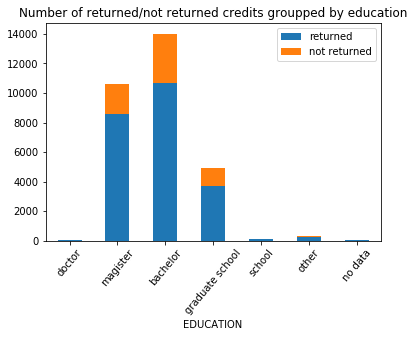

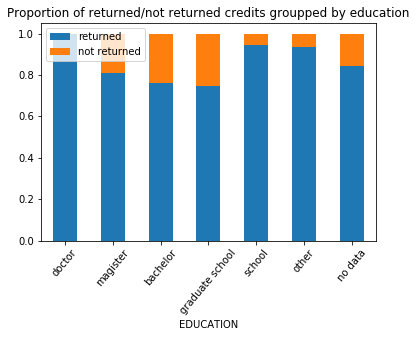

In [20]:
edu_data = credit_data[["EDUCATION", "default"]].groupby(["EDUCATION", "default"]).size().unstack()
axes = edu_data.plot.bar(stacked=True, rot=50)
pylab.title("Number of returned/not returned credits groupped by education")
axes.legend(["returned", "not returned"]);
pylab.xticks(np.arange(7), ("doctor", "magister", "bachelor", "graduate school", "school", "other", "no data"))

edu_data.iloc[0] /= edu_data.iloc[0].sum()
edu_data.iloc[1] /= edu_data.iloc[1].sum()
edu_data.iloc[2] /= edu_data.iloc[2].sum()
edu_data.iloc[3] /= edu_data.iloc[3].sum()
edu_data.iloc[4] /= edu_data.iloc[4].sum()
edu_data.iloc[5] /= edu_data.iloc[5].sum()
edu_data.iloc[6] /= edu_data.iloc[6].sum()
axes = edu_data.plot.bar(stacked=True, rot=50)
pylab.title("Proportion of returned/not returned credits groupped by education")
axes.legend(["returned", "not returned"]);
pylab.xticks(np.arange(7), ("doctor", "magister", "bachelor", "graduate school", "school", "other", "no data"))
pylab.show()

Let's count cramer_v measure to see if that measure is above 0

In [21]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
cramers_v(credit_data.EDUCATION, credit_data.default)

0.07239281703731822

Let's run chi square test to prove that correlation exists.
* H0: X1 and X2 are independent
* H1: H0 is invalid, i.e. X1 and X2 are not independent

In [22]:
edu_confusion_matrix = pd.crosstab(credit_data.EDUCATION, credit_data.default)
chi, pvalue, dof, exp = chi2_contingency(edu_confusion_matrix)
print("chi value:", chi)
print("p-value:", pvalue)
print("dof:", dof)
print("exp:", exp)

chi value: 163.21655786997073
p-value: 1.2332626245415605e-32
dof: 6
exp: [[1.0903200e+01 3.0968000e+00]
 [8.2435980e+03 2.3414020e+03]
 [1.0926564e+04 3.1034360e+03]
 [3.8293596e+03 1.0876404e+03]
 [9.5792400e+01 2.7207600e+01]
 [2.1806400e+02 6.1936000e+01]
 [3.9718800e+01 1.1281200e+01]]


According to chi square test, the p-value is less than 0.05, so H0 is rejected in favor of H1 and there is some dependency between education and default. 

In [23]:
edu_confusion_matrix - exp

default,0,1
EDUCATION,,
0,3.0968,-3.0968
1,305.4020,-305.4020
2,-226.5640,226.5640
3,-149.3596,149.3596
4,20.2076,-20.2076
5,43.9360,-43.9360
6,3.2812,-3.2812


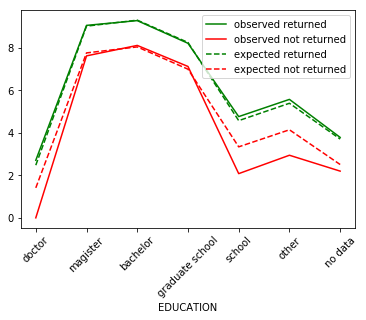

In [24]:
# I have applied log(1+x) function to normalize/scale the data.
axes = edu_confusion_matrix.apply(lambda x: np.log(1+x)).plot(kind='line', color=("green", "red"))
(pd.DataFrame(exp)).apply((lambda x: np.log(1+x))).plot(kind='line', color=("green", "red"), linestyle="dashed", ax=axes, rot=45)
pylab.legend(["observed returned", "observed not returned", "expected returned", "expected not returned"])
pylab.xticks(np.arange(7), ("doctor", "magister", "bachelor", "graduate school", "school", "other", "no data"))

plt.show()

It's not clear what to do to answer the questions about best/worst education indicator to return a credit.
Should we build a regression? Or should we somehow calculate correlation each by single education.
I will provide an answer using my proportion graph.

In [25]:
edu_data

default,0,1
EDUCATION,,
0,1.000000,NaN
1,0.807652,0.192348
2,0.762651,0.237349
3,0.748424,0.251576
4,0.943089,0.056911
5,0.935714,0.064286
6,0.843137,0.156863


* According to proportions, the "doctor" edu is the perfect indicator that client will return the credit.
* "Graduate school" is an education for which we spotted the highest number of defaults.

### Task 4: Marriage

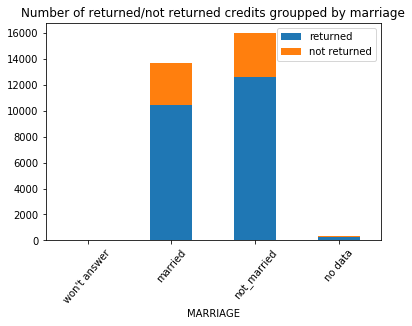

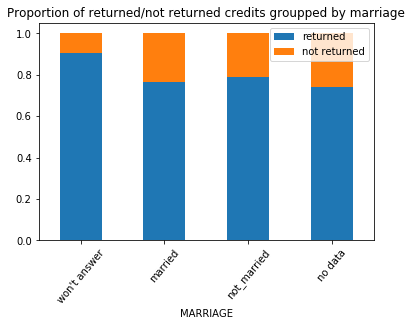

In [26]:
mariage_data = credit_data[["MARRIAGE", "default"]].groupby(["MARRIAGE", "default"]).size().unstack()
axes = mariage_data.plot.bar(stacked=True, rot=50)
pylab.title("Number of returned/not returned credits groupped by marriage")
axes.legend(["returned", "not returned"]);
pylab.xticks(np.arange(4), ("won't answer", "married", "not_married", "no data"))

mariage_data.iloc[0] /= mariage_data.iloc[0].sum()
mariage_data.iloc[1] /= mariage_data.iloc[1].sum()
mariage_data.iloc[2] /= mariage_data.iloc[2].sum()
mariage_data.iloc[3] /= mariage_data.iloc[3].sum()
axes = mariage_data.plot.bar(stacked=True, rot=50)
pylab.title("Proportion of returned/not returned credits groupped by marriage")
axes.legend(["returned", "not returned"]);
pylab.xticks(np.arange(4), ("won't answer", "married", "not_married", "no data"))
pylab.show()

Well, the data is very unbalanced, we have almost no values for marriage 0(won't asnwer) and 3(no data).
We can drop the marriage 0 and 3 data because the question of the task: how marriage correlates with default. 0 and 3 can be considered as status is unknown, it makes sense to work only with 2(married) and 3(not married) columns.
Since we are left with just two binary variables: married/not maried and default/not default we can apply matthews correlation measure. 

In [27]:
from sklearn.metrics import matthews_corrcoef

mariage_data = credit_data[["MARRIAGE", "default"]].groupby(["MARRIAGE", "default"]).size().unstack()
mariage_data.drop(index=[0,3], inplace=True)
mariage_data

default,0,1
MARRIAGE,,
1,10453,3206
2,12623,3341


In [28]:
def MCC(a, b, c, d):
    numerator = a*d - b*c
    d_sum = (a + b) * (a + c) * (b + d) * (c + d)
    denominator = sqrt(d_sum)
    return numerator/denominator
MCC(10453, 3206, 12623, 3341)    

-0.030555369920445503

There seems to be a little correlation between mariage and returning/not_returning credit.
It was partially noticable from the diagram. For groups 2(married) and 3(no_married) the proportion of returned/not returned credits were close to each other, but not exactly the same, i.e. beign married reduces the chance to return a credit slightly.

Let's use chi square criteria to prove it.
* H0: MCCx1,x2 == 0
* H1: MCCx1,x2 <> 0

In [29]:
mariage_contingency = np.array([[10453, 3206], [12623, 3341]])
chi, pvalue, dof, _ = chi2_contingency(mariage_contingency)
print("chi value:", chi)
print("p-value:", pvalue)
print("dof:", dof)

# additional output for all mariage types
confusion_matrix = pd.crosstab(credit_data.MARRIAGE, credit_data.default)
chi2_contingency(confusion_matrix)

chi value: 27.5094090929579
p-value: 1.5633210355976673e-07
dof: 1


(35.66239583433609,
 8.825862457577375e-08,
 3,
 array([[4.20552000e+01, 1.19448000e+01],
        [1.06376292e+04, 3.02137080e+03],
        [1.24327632e+04, 3.53123680e+03],
        [2.51552400e+02, 7.14476000e+01]]))

According to chi square criteria in both cases (with married/non married only or all features) H0 is rejected in favor of H1, so there IS a correlation between mariage and dafault.

### Task 5: Age

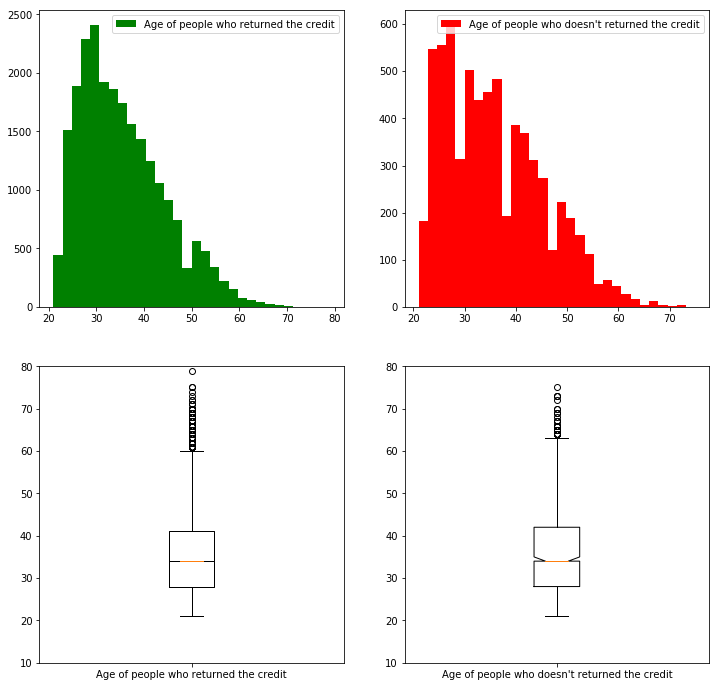

In [30]:
pylab.figure(figsize=(12,12))
pylab.subplot(2,2,1)
pylab.hist(returned_data.AGE, bins=30, label="Age of people who returned the credit", color="g")
pylab.legend()

pylab.subplot(2,2,2)
pylab.hist(not_returned_data.AGE, bins=30, label="Age of people who doesn't returned the credit", color="r")
pylab.legend()

pylab.subplot(2,2,3)
pylab.boxplot(returned_data.AGE, notch=True, bootstrap=1000, labels=['Age of people who returned the credit'])
pylab.ylim(10, 80)

pylab.subplot(2,2,4)
pylab.boxplot(not_returned_data.AGE, notch=True, bootstrap=1000,labels=["Age of people who doesn't returned the credit"])
pylab.ylim(10, 80)
pylab.show()

Even visually, it seems like the medians are the same, but let's check by looking at the confidence intervals and confidence interval for the difference

In [31]:
# get values first
returned_age_values     = returned_data.AGE.values
not_returned_age_values = not_returned_data.AGE.values

returned_age_median_scores     = list(map(np.median, get_bootstrap_samples(returned_age_values, 1000)))
not_returned_age_median_scores = list(map(np.median, get_bootstrap_samples(not_returned_age_values, 1000)))

# Pointwise
print("Pointwise difference between medians:", np.median(returned_age_values) - np.median(not_returned_age_values))

# Confidence interval of returned/not-returned group limit median
print("95% confidence interval for the returned group limit",  stat_intervals(returned_age_median_scores, 0.05))
print("95% confidence interval for the not returned group limit",  stat_intervals(not_returned_age_median_scores, 0.05))

print()
# Confidence interval of difference between medians
delta_median_scores = list(map(lambda x: x[0] - x[1], zip(returned_age_median_scores, not_returned_age_median_scores)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

Pointwise difference between medians: 0.0
95% confidence interval for the returned group limit [34. 34.]
95% confidence interval for the not returned group limit [34. 35.]

95% confidence interval for the difference between medians [-1.  0.]


$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

(H1): distributions are equal but shifted is alternative to (H0): distributions are equal

In [33]:
print("p-value: %f" % permutation_test(returned_age_values, not_returned_age_values, max_permutations = 5000))

p-value: 0.016200


In [34]:
stats.mannwhitneyu(returned_age_values, not_returned_age_values)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

Well, it's surprising(technically, intervals are the same, and confidence interval for the difference contiins 0) but the p-value is less than alpha=0.05 threshold which means that the distributions are not the same(H0 is rejected in favor of H1).
At the same time based on the confidence interval for the difference we can say, that even if distributions are not the same the difference of their medians doesn't have any practical significance.